In [19]:
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
import torch
%pylab inline
import numpy as np
from tqdm import trange
np.set_printoptions(suppress=True)

Populating the interactive namespace from numpy and matplotlib


In [2]:
import scratchdiff.Unit as sd
from scratchdiff.Unit import Unit

In [3]:
def fetch_mnist():
  import gzip
  parse = lambda file: np.frombuffer(gzip.open(file).read(), dtype=np.uint8).copy()
  X_train = parse("mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28*28)).astype(np.float32)
  Y_train = parse("mnist/train-labels-idx1-ubyte.gz")[8:]
  X_test = parse("mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28*28)).astype(np.float32)
  Y_test = parse("mnist/t10k-labels-idx1-ubyte.gz")[8:]
  return X_train, Y_train, X_test, Y_test

X_train, Y_train, X_test, Y_test = fetch_mnist()

(<matplotlib.image.AxesImage at 0x7fd85dbd5a90>, 5)

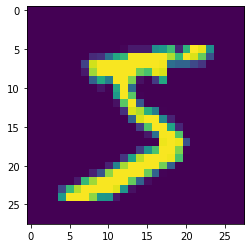

In [4]:
plt.imshow(X_train[0].reshape((28,28))) , Y_train[0]

In [5]:
BS = 28
vec_dim = X_train.shape[-1] # 784

class MLP:
    def __init__(self):
        self.W1 = Unit(np.random.uniform(-1., 1., size=(vec_dim,128))/np.sqrt(vec_dim*128))
        self.W2 = Unit(np.random.uniform(-1., 1., size=(128,10))/np.sqrt(128*10))
    
    def forward(self, x):
        l1 = sd.relu(sd.matmul(x,self.W1))
        l2 = sd.matmul(l1,self.W2)
        return sd.logsoftmax(l2)  
        

In [6]:
# s = model.forward(X_train[0].reshape((-1, 28*28)))
# print(s.shape)
# np.argmax(s.data, axis=1)

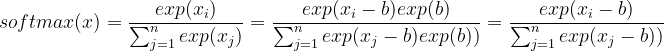
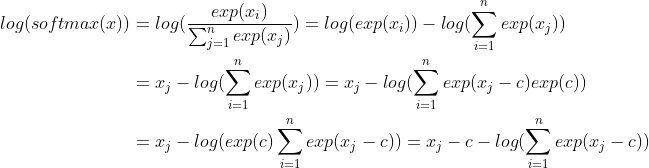

In [7]:

class Optimizer:
    def __init__(self, params):
        self.params = params
        
class SGD(Optimizer):
    def __init__(self, params, lr=0.001):
        super(SGD, self).__init__(params)
        self.lr = lr
        
    def step(self):
        for t in self.params:
            t.data -= self.lr * t.grad.data
    
    def zero_grad(self):
        for t in self.params:
            t.zero_grad()



In [15]:
from tqdm import trange
model = MLP()
sgd = SGD([model.W1, model.W2])
losses = []
accuracies = []
t = trange(1000)
for i in t:
    sgd.zero_grad()
    samp = np.random.randint(0, X_train.shape[0], size=(BS))
    x = Unit(X_train[samp].reshape((-1, 28*28)))
    Y = Y_train[samp]
    y = np.zeros((BS, 10))
    y[range(BS),Y] = -10 
    Y_hat = model.forward(x)
#     print(Y_hat.shape)
    celoss = sd.div(sd.sum(sd.mul(Y_hat, y),keepdims=False), 280)
    celoss.backward_pass()
    sgd.step()
    
    cat = np.argmax(Y_hat.data, axis=1)
    accuracy = (cat == Y).mean()
    
    loss = celoss.data
    losses.append(loss)
    accuracies.append(accuracy)
    t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))

        

loss 0.07 accuracy 1.00: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 320.65it/s]


In [16]:
Y_test_preds_out = model.forward(X_test.reshape((-1, 28*28)))
Y_test_preds = np.argmax(Y_test_preds_out.data, axis=1)


In [17]:
(Y_test == Y_test_preds).mean()

0.954

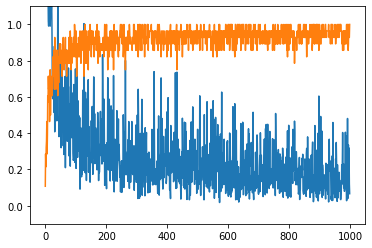

In [20]:
plt.ylim(-0.1, 1.1)
plot(losses)
plot(accuracies)